# <span style="font-width:bold; font-size: 3rem; color:#1EB182;">**Hopsworks Feature Store** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Model training & UI Exploration</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/advanced_tutorials/nyc_taxi_fares/4_model_training_and_registration.ipynb)


## 🗒️ This notebook is divided into 3 main sections:
1. **Loading the training data**,
2. **Train the model**,
3. **Register model to Hopsworks model registry**.

![tutorial-flow](../../images/03_model.png)

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/164


Connected. Call `.close()` to terminate connection gracefully.


---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

To retrieve training dataset from **Feature Store** you retrieve **Feature View** using `FeatureStore.get_feature_view` method.

Then you can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_training_dataset` method.


In [2]:
nyc_fares_fv = fs.get_feature_view(
    name = 'nyc_taxi_fares_fv',
    version = 1
)

In [7]:
X_train, X_test, y_train, y_test = nyc_fares_fv.get_train_test_split(
    training_dataset_version=2
)

In [9]:
X_test.head(5)

,tolls,ride_id,passenger_count,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour
0,2.0,caaed68e832bc666e395ee2b87abefd6,4,46.824484,59.600489,19.284968,52.205463,6.697652,49.066129,12.063847,2020,3,15
1,5.0,4b5915f26bd5398b5107eff005b25c04,4,20.223673,49.763298,30.103905,66.083788,45.895022,49.260332,29.053953,2020,1,3
2,3.0,a1c997a429520ff5ed7ec4596dcdd0ef,2,49.578575,62.345298,29.546261,72.363396,25.947280,57.359774,19.015494,2020,4,10
3,0.0,b359b0d9ec8747ab2100de374183b7fe,4,80.124239,9.880610,80.720908,30.843519,88.744313,19.025863,74.816781,2020,2,17
4,1.0,9e96e1a8cb715481af58a957a0696142,4,37.456967,10.777383,32.624985,31.699697,29.054899,18.250773,22.168216,2020,3,16


In [10]:
cols_to_drop = ['ride_id']

In [11]:
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [12]:
import numpy as np


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [13]:
y_test

array([  4.,   4.,   6.,   9.,   9.,  10.,  15.,  17.,  17.,  17.,  17.,
        19.,  19.,  20.,  21.,  21.,  25.,  25.,  27.,  28.,  29.,  30.,
        32.,  35.,  36.,  37.,  38.,  44.,  44.,  44.,  45.,  47.,  48.,
        50.,  52.,  52.,  53.,  57.,  60.,  61.,  63.,  70.,  74.,  77.,
        79.,  80.,  83.,  83.,  85.,  86.,  87.,  90.,  93.,  94.,  95.,
        98.,  99., 101., 103., 108., 110., 110., 113., 113., 115., 121.,
       121., 121., 128., 129., 131., 131., 132., 132., 134., 138., 140.,
       141., 148., 148., 151., 152., 153., 153., 154., 155., 159., 160.,
       164., 166., 172., 173., 177., 181., 183., 183., 185., 188., 191.,
       191., 193., 194., 195., 198., 200., 202., 202., 204., 204., 205.,
       205., 206., 211., 211., 213., 216., 219., 225., 228., 229., 234.,
       235., 235., 241., 242., 246.])

---

### <span style="color:#ff5f27;">📝 Importing Libraries</span>

In [14]:
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_absolute_error, r2_score

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [15]:
# hyperparameter tuning will not be performed cause the data was generated randomly
lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [16]:
X_test.columns

Index(['tolls', 'passenger_count', 'distance', 'pickup_distance_to_jfk',
       'dropoff_distance_to_jfk', 'pickup_distance_to_ewr',
       'dropoff_distance_to_ewr', 'pickup_distance_to_lgr',
       'dropoff_distance_to_lgr', 'year', 'weekday', 'hour'],
      dtype='object')

In [17]:
lr_preds = lr_model.predict(X_test)

lr_r2_score = r2_score(y_test, lr_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)

print("LogisticRegression R²:", lr_r2_score)
print("LogisticRegression MAE:", lr_mae)

LogisticRegression R²: -0.5209443154885003
LogisticRegression MAE: 68.61111111111111


### Remember, the data is random, so the results are not accurate at all.

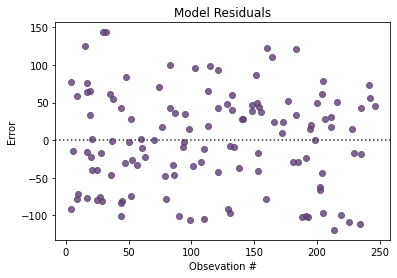

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.residplot(y_test, lr_preds, color='#613F75')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [19]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


Before registering the model we will export it as a pickle file using joblib.

In [20]:
import joblib

joblib.dump(lr_model, 'model.pkl')

['model.pkl']

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'tolls', 'type': 'float64'},
   {'name': 'passenger_count', 'type': 'int64'},
   {'name': 'distance', 'type': 'float64'},
   {'name': 'pickup_distance_to_jfk', 'type': 'float64'},
   {'name': 'dropoff_distance_to_jfk', 'type': 'float64'},
   {'name': 'pickup_distance_to_ewr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_ewr', 'type': 'float64'},
   {'name': 'pickup_distance_to_lgr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_lgr', 'type': 'float64'},
   {'name': 'year', 'type': 'int64'},
   {'name': 'weekday', 'type': 'int64'},
   {'name': 'hour', 'type': 'int64'}]},
 'output_schema': {'tensor_schema': {'shape': '(524,)', 'type': 'float64'}}}

With the schema in place, you can finally register our model.

In [22]:
metrics = {
    'mae': lr_mae,
    'r2_score': lr_r2_score
}


In [23]:
model = mr.sklearn.create_model(
    name="nyc_taxi_fares_model",
    metrics=metrics,
    description="LogisticRegression.",
    input_example=X_test.sample(),
    model_schema=model_schema
)

model.save('model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/164/models/nyc_taxi_fares_model/10


Model(name: 'nyc_taxi_fares_model', version: 10)

In [24]:
# how to get a best model (when you have many of them)

# EVALUATION_METRIC="mae"  # or r2_score
# SORT_METRICS_BY="max" # your sorting criteria

# # get best model based on custom metrics
# best_model = mr.get_best_model("nyc_taxi_fares_model",
#                                EVALUATION_METRIC,
#                                SORT_METRICS_BY)

 Here you have also saved an input example from the training data, which can be helpful for test purposes.

 It's important to know that every time you save a model with the same name, a new version of the model will be saved, so nothing will be overwritten. In this way, you can compare several versions of the same model - or create a model with a new name, if you prefer that.

---